In [6]:
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.applications.densenet import DenseNet121,preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.optimizers import SGD,Adam 
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
import cv2
import tensorflow as tf
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
import zipfile
from keras.preprocessing import image 
nltk.download('punkt')
import math

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
densenet = DenseNet121(weights='/content/drive/MyDrive/Project Data/brucechou1983_CheXNet_Keras_0.3.0_weights.h5',classes = 14,input_shape=(224,224,3))
CNN1 = Model(inputs=[densenet.input], outputs=[densenet.layers[-2].output])
CNN1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.692339 to fit



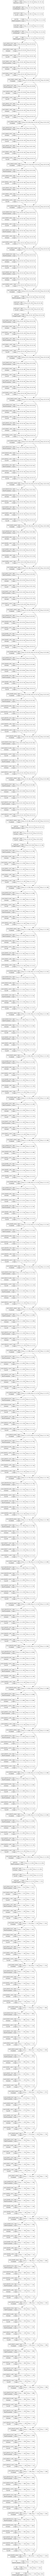

In [10]:
plot_model(CNN1,show_shapes = True)


In [ ]:
img = cv2.imread("/content/drive/MyDrive/Project Data/NLMCXR_png/CXR1000_IM-0003-1001.png", cv2.IMREAD_UNCHANGED)
print('Image Dimensions: ', img.shape)

In [ ]:
df4 = pd.read_excel('/content/drive/MyDrive/Project Data/X-ray2.xlsx')
df4.drop(df4.columns[df4.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df4['Xray_arrays'] = 'x'

In [ ]:
for i in range(0,len(df4)):
    xray1 = cv2.imread(r'/content/drive/MyDrive/Project Data/NLMCXR_png/' + df4['Image_file1'][i])
    xray1 = cv2.resize(xray1,(224,224))
    xray1 = tf.cast(xray1, tf.float32) / 255.0
    xray1 = tf.expand_dims(xray1, axis=0)
    xray1 = preprocess_input(xray1)
    feat1 = CNN1.predict(xray1, verbose=0)
    xray2 = cv2.imread(r'/content/drive/MyDrive/Project Data/NLMCXR_png/'+  df4['Image_file2'][i])
    xray2 = cv2.resize(xray2,(224,224))
    xray2 = tf.cast(xray2, tf.float32) / 255.0
    xray2 = tf.expand_dims(xray2, axis=0)
    xray2 = preprocess_input(xray2)
    feat2 = CNN1.predict(xray2, verbose=0)
    comb = np.concatenate((feat1, feat2), axis=1)
    comb = np.reshape(comb, comb.shape[1])
    df4['Xray_arrays'][i] = np.array(comb)


In [ ]:
df4

In [ ]:

df4.to_excel('/content/drive/MyDrive/Project Data/X-raywithChex.xlsx')
df4.to_pickle('/content/drive/MyDrive/Project Data/X-raywithChex.pkl') 

In [11]:
df5 = pd.read_pickle('/content/drive/MyDrive/Project Data/X-raywithChex.pkl')
df5.drop(df5.columns[df5.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [12]:
df5

,Patient_ID,Image_file1,Image_file2,Report_ID,Impression,Impression_token,Xray_arrays
0,CXR1,CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png,1.xml,normal chest,begin normal chest end,"[0.0, 0.0027834198, 0.002356792, 0.0, 0.031117..."
1,CXR2,CXR2_IM-0652-1001.png,CXR2_IM-0652-2001.png,2.xml,no acute pulmonary findings,begin no acute pulmonary findings end,"[0.0, 0.0027878722, 0.0023591958, 0.0, 0.03112..."
2,CXR3,CXR3_IM-1384-1001.png,CXR3_IM-1384-2001.png,3.xml,no displaced rib fractures pneumothorax or ple...,begin no displaced rib fractures pneumothorax ...,"[0.0, 0.0027874026, 0.0023608117, 0.0, 0.03112..."
3,CXR4,CXR4_IM-2050-2001.png,CXR4_IM-2050-1001.png,4.xml,bullous emphysema and interstitial fibrosis pr...,begin bullous emphysema and interstitial fibro...,"[0.0, 0.0027906818, 0.0023535655, 0.0, 0.03108..."
4,CXR5,CXR5_IM-2117-1004003.png,CXR5_IM-2117-1003002.png,5.xml,no acute cardiopulmonary abnormality,begin no acute cardiopulmonary abnormality end,"[0.0, 0.0027835937, 0.00235545, 0.0, 0.0311142..."
...,...,...,...,...,...,...,...
3815,CXR3995,CXR3995_IM-2046-2001.png,CXR3995_IM-2046-1001.png,3995.xml,interval resolution of bibasilar airspace dise...,begin interval resolution of bibasilar airspac...,"[0.0, 0.002785333, 0.0023592678, 0.0, 0.031103..."
3816,CXR3996,CXR3996_IM-2047-3001.png,CXR3996_IM-2047-1001.png,3996.xml,clear lungs no acute cardiopulmonary abnormality,begin clear lungs no acute cardiopulmonary abn...,"[0.0, 0.0027871705, 0.0023587241, 0.0, 0.03109..."
3817,CXR3997,CXR3997_IM-2048-1001.png,CXR3997_IM-2048-1002.png,3997.xml,no acute findings no evidence for active tb,begin no acute findings no evidence for active...,"[0.0, 0.0027841341, 0.002357168, 0.0, 0.031120..."
3818,CXR3998,CXR3998_IM-2048-1002.png,CXR3998_IM-2048-1001.png,3998.xml,heart size is normal and the lungs are clear,begin heart size is normal and the lungs are c...,"[0.0, 0.002788653, 0.0023571558, 0.0, 0.031083..."


In [13]:
tokens=[]
cap_len = []
for i in range (0,len(df5)):
    temp = (word_tokenize(df5['Impression_token'][i]))
    cap_len.append(len(temp))
    for j in temp:
        tokens.append(j)
cap_len = sorted(cap_len)
x = np.quantile(cap_len, [0,0.25,0.5,0.75,0.80,0.95,0.99,1])
print('The minimum length of a caption is :',min(cap_len))
print('The maximum length of a caption is :',max(cap_len))
print('The 25th percentile length of a caption is :',x[1])
print('The 50th percentile length of a caption is :',x[2])
print('The 75th percentile length of a caption is :',x[3])
print('The 80th percentile length of a caption is :',x[4])
print('The 95th percentile length of a caption is :',x[5])
print('The 99th percentile length of a caption is :',x[6])

The minimum length of a caption is : 3
The maximum length of a caption is : 124
The 25th percentile length of a caption is : 6.0
The 50th percentile length of a caption is : 7.0
The 75th percentile length of a caption is : 13.0
The 80th percentile length of a caption is : 16.0
The 95th percentile length of a caption is : 35.0
The 99th percentile length of a caption is : 55.809999999999945


In [ ]:
sum(i < 54 for i in cap_len)

3774

In [14]:
train, test = train_test_split(df5, test_size=0.2, random_state=75, shuffle=True)

In [15]:
train, val = train_test_split(train, test_size=0.125, random_state=75, shuffle=True)

In [16]:
train.shape

(2674, 7)

In [17]:
val.shape

(382, 7)

In [18]:
test.shape

(764, 7)

In [19]:
docket = Tokenizer(oov_token='UNK')
impression_tokens = []
for i in range(0,len(df5)):
    impression_tokens.append(df5['Impression_token'][i])
docket.fit_on_texts(impression_tokens)


In [20]:
corpus = len(docket.word_index) + 1

In [77]:
index_train_list = list(train.index.values) 
train_iterator = iter(index_train_list)
index_val_list = list(val.index.values) 
val_iterator = iter(index_val_list)
index_test_list = list(test.index.values) 
test_iterator = iter(index_test_list)

In [21]:
def batch_generator(data,batch_size,ix_list,docket,iterator,opt_length,corpus):
  while True:      
      lst=[]
      features = []
      x_cap = []
      y_cap = []
      for i in range(0,batch_size):
          try:
              lst.append(next(iterator))
          except StopIteration:
              i = batch_size+1
              break
      if (len(lst)!=0):        
        for index in lst:
          sent = data['Impression_token'][index]
          t2seq = docket.texts_to_sequences([sent])[0]
          for i in range (0,len(t2seq)-1):
              x_sent = t2seq[:i+1]
              y_sent = t2seq[i+1:i+2]
              x_sent= pad_sequences([x_sent], maxlen=opt_length,padding='post' ,truncating='post')[0]
              y_sent = to_categorical([y_sent], num_classes=corpus)[0]
              features.append(data['Xray_arrays'][index])
              x_cap.append(x_sent)
              y_cap.append(y_sent)
        yield [np.array(features), np.array(x_cap)], np.array(y_cap)
      else:
        return 
      
        
     

    

In [ ]:
index_val_list = list(val.index.values) 
val_iterator = iter(index_val_list)
opt_length =56

In [79]:
c = next(batch_generator(df5,1,index_train_list,docket,train_iterator,56,1551))

In [124]:
index_test_list

[1528,
 148,
 1731,
 1905,
 1113,
 1993,
 3812,
 1958,
 2144,
 179,
 586,
 2178,
 3537,
 742,
 3331,
 2157,
 2314,
 2452,
 2745,
 1624,
 1423,
 1006,
 1520,
 3010,
 2552,
 3053,
 467,
 2039,
 1803,
 2162,
 1082,
 421,
 2473,
 2945,
 3583,
 699,
 1213,
 2513,
 2283,
 2591,
 3065,
 2370,
 2048,
 2410,
 375,
 2205,
 1369,
 3445,
 3110,
 2769,
 2261,
 2961,
 2475,
 229,
 1012,
 63,
 3283,
 3042,
 3392,
 789,
 167,
 1601,
 2777,
 1060,
 2114,
 1099,
 2237,
 1517,
 1273,
 1297,
 451,
 3350,
 2539,
 2528,
 842,
 271,
 508,
 821,
 1052,
 777,
 3655,
 276,
 3118,
 2315,
 125,
 2013,
 3011,
 2425,
 681,
 1556,
 352,
 419,
 3026,
 2251,
 3280,
 2679,
 1668,
 3798,
 1411,
 2388,
 2893,
 519,
 295,
 312,
 1295,
 2750,
 2667,
 2916,
 894,
 531,
 3243,
 806,
 734,
 1589,
 3686,
 2436,
 2722,
 2365,
 1657,
 3759,
 2949,
 2325,
 994,
 442,
 2059,
 627,
 3516,
 3206,
 3205,
 3266,
 1505,
 1308,
 3287,
 2032,
 123,
 3211,
 126,
 2413,
 1786,
 589,
 3159,
 1667,
 496,
 1967,
 3762,
 430,
 2837,
 2027,
 79

In [ ]:
x

array([[0.        , 0.00278884, 0.00235757, ..., 0.82218534, 0.7968102 ,
        0.6713742 ],
       [0.        , 0.00278884, 0.00235757, ..., 0.82218534, 0.7968102 ,
        0.6713742 ],
       [0.        , 0.00278884, 0.00235757, ..., 0.82218534, 0.7968102 ,
        0.6713742 ],
       ...,
       [0.        , 0.00278619, 0.00236085, ..., 0.821988  , 0.7968104 ,
        0.67119014],
       [0.        , 0.00278619, 0.00236085, ..., 0.821988  , 0.7968104 ,
        0.67119014],
       [0.        , 0.00278619, 0.00236085, ..., 0.821988  , 0.7968104 ,
        0.67119014]], dtype=float32)

In [ ]:
z.shape

(348, 1551)

In [ ]:
vv=[]
for i in index_train_list:
  vv.append(df5['Impression_token'][i])

In [ ]:
count = 0
for elem in vv[128:256]:
  count+=len(elem.split(' '))
print(count-128)


1479


In [23]:
glove_dict = {}
counter=0
with open('/content/drive/MyDrive/Project Data/Glove Vector files/glove.6B.200d.txt') as file:
    for line in file:
      word = line.split()[0] 
      vector = np.array(line.split()[1:], dtype ='float32')
      glove_dict[word]= vector

In [24]:
print("The number of words with vector embedding we have in the 200-d glove library is :",len(glove_dict))

The number of words with vector embedding we have in the 200-d glove library is : 400000


In [25]:

token_map = docket.word_index
word_dim = 200

glove_matrix = np.zeros((corpus, word_dim)) 
for key, value in token_map.items():
  if key in glove_dict :
    glove_vector = glove_dict[key]
    glove_matrix[value] = glove_vector
  else:
    glove_matrix[value] = np.zeros((1, word_dim))


In [26]:
opt_length = 56
word_dim = 200
# Encoder
# Image part
img_input = Input(shape=(2048,))
idrop1 = Dropout(0.4)(img_input)
idense2 = Dense(256, activation='relu')(idrop1)

# Caption part
cap_input = Input(shape=(opt_length,))
cap_embed = Embedding(corpus, word_dim, mask_zero=True)(cap_input)
capdrop1 = Dropout(0.3)(cap_embed)
lstm = LSTM(256)(capdrop1)




# Decoder
add_layer = add([idense2, lstm])
cumu_dense = Dense(256, activation='relu')(add_layer)
cap_output = Dense(corpus, activation='softmax')(cumu_dense)


 

In [27]:
model1 = Model(inputs=[img_input, cap_input], outputs=cap_output)

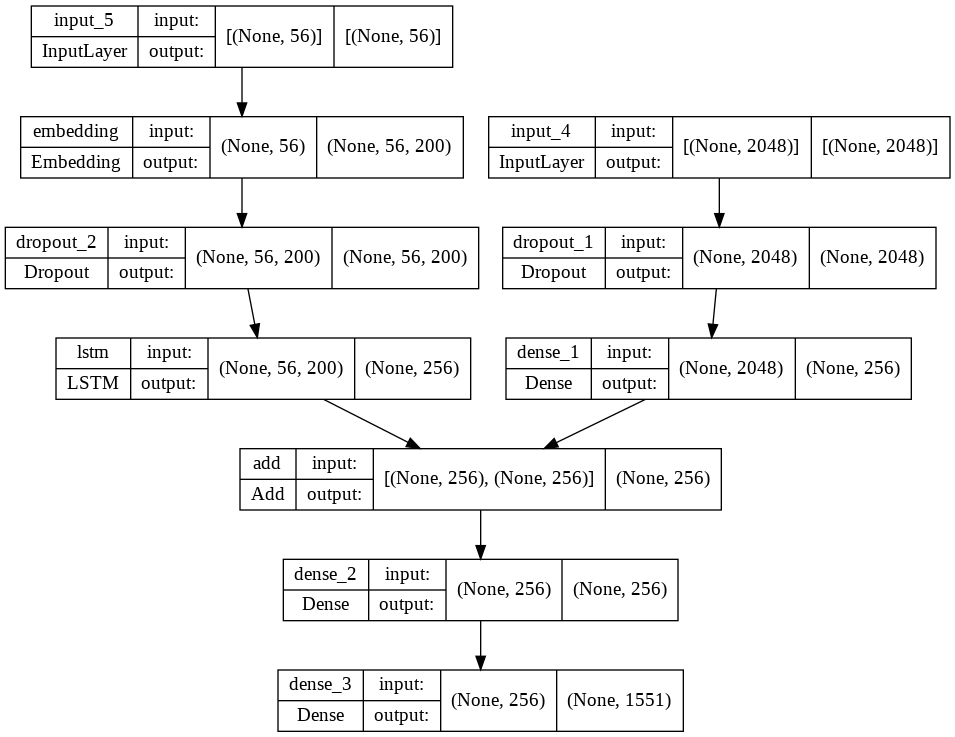

In [28]:
 plot_model(model1, show_shapes=True)

In [29]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 56)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 56, 200)      310200      ['input_5[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [ ]:
model1.layers[2]

In [ ]:
model1.layers[2].set_weights([glove_matrix])
model1.layers[2].trainable = False

In [ ]:
mod1_cb1= ModelCheckpoint(filepath='/content/drive/MyDrive/Project Data/Model1/mod1_cb1',save_weights_only=True,verbose=0,mode ='auto',save_best_only = False)

In [ ]:
def model_training(epochs,train,test,val,opt_length,batch_size,tokenizer,checkpoint,model):
    es_monitor = 3
    best_val = 1000.0000
    counter = 0
    for epoch in range(epochs):
      print('Epoch no. {}'.format(epoch + 1))
      index_train_list = list(train.index.values) 
      train_iterator = iter(index_train_list)
      index_val_list = list(val.index.values) 
      val_iterator = iter(index_val_list)
      index_test_list = list(test.index.values) 
      test_iterator = iter(index_test_list)
      train_steps = math.ceil(len(train)/batch_size)
      val_steps = math.ceil(len(val)/batch_size)
      train_generator = batch_generator(df5,batch_size,index_train_list,docket,train_iterator,opt_length,corpus)
      val_generator = batch_generator(df5,batch_size,index_val_list,docket,val_iterator,opt_length,corpus)
      history=model.fit(train_generator, epochs=1,steps_per_epoch = train_steps,verbose=1,validation_data = val_generator, validation_steps =val_steps, callbacks=[checkpoint])
      validation_loss = float(format(history.history['val_loss'][0],".4f"))
      counter+=1
      if validation_loss <= best_val:
        best_val = validation_loss
        counter = 0
      if counter == es_monitor and epoch<epochs-1:
        print ("Stopping early at Epoch no. {} as validation loss is increasing".format(epoch+1))
        break

In [ ]:
opt = Adam(learning_rate=10e-5)
model1.compile(loss='categorical_crossentropy', optimizer=opt)
model_training(50,train,test,val,56,32,docket,mod1_cb1,model1)

Epoch no. 1
84/84 [==============================] - 130s 1s/step - loss: 6.0391 - val_loss: 4.8796
Epoch no. 2
84/84 [==============================] - 119s 1s/step - loss: 4.8929 - val_loss: 4.5392
Epoch no. 3
84/84 [==============================] - 117s 1s/step - loss: 4.6349 - val_loss: 4.3068
Epoch no. 4
84/84 [==============================] - 117s 1s/step - loss: 4.4433 - val_loss: 4.1480
Epoch no. 5
84/84 [==============================] - 115s 1s/step - loss: 4.3070 - val_loss: 4.0370
Epoch no. 6
84/84 [==============================] - 118s 1s/step - loss: 4.1954 - val_loss: 3.9447
Epoch no. 7
84/84 [==============================] - 118s 1s/step - loss: 4.0975 - val_loss: 3.8632
Epoch no. 8
84/84 [==============================] - 117s 1s/step - loss: 4.0069 - val_loss: 3.7897
Epoch no. 9
84/84 [==============================] - 117s 1s/step - loss: 3.9222 - val_loss: 3.7239
Epoch no. 10
84/84 [==============================] - 118s 1s/step - loss: 3.8451 - val_loss: 3.6673

In [ ]:
mod1_cb2= ModelCheckpoint(filepath='/content/drive/MyDrive/Project Data/Model1/mod1_cb2',save_weights_only=True,verbose=0,mode ='auto',save_best_only = False)
model1.load_weights('/content/drive/MyDrive/Project Data/Model1/mod1_cb1')
opt = Adam(learning_rate=10e-7)
model1.compile(loss='categorical_crossentropy', optimizer=opt)
model_training(10,train,test,val,56,8,docket,mod1_cb2,model1)

Epoch no. 1
335/335 [==============================] - 185s 538ms/step - loss: 2.6194 - val_loss: 3.1225
Epoch no. 2
335/335 [==============================] - 175s 523ms/step - loss: 2.6117 - val_loss: 3.1212
Epoch no. 3
335/335 [==============================] - 180s 536ms/step - loss: 2.6107 - val_loss: 3.1204
Epoch no. 4
335/335 [==============================] - 178s 532ms/step - loss: 2.6097 - val_loss: 3.1196
Epoch no. 5
335/335 [==============================] - 178s 530ms/step - loss: 2.6069 - val_loss: 3.1191
Epoch no. 6
335/335 [==============================] - 176s 526ms/step - loss: 2.6074 - val_loss: 3.1186
Epoch no. 7
335/335 [==============================] - 173s 515ms/step - loss: 2.6076 - val_loss: 3.1186
Epoch no. 8
335/335 [==============================] - 172s 512ms/step - loss: 2.6083 - val_loss: 3.1186
Epoch no. 9
335/335 [==============================] - 170s 508ms/step - loss: 2.6054 - val_loss: 3.1182
Epoch no. 10
335/335 [==============================] -

In [ ]:
mod1_cb3= ModelCheckpoint(filepath='/content/drive/MyDrive/Project Data/Model1/mod1_cb3',save_weights_only=True,verbose=0,mode ='auto',save_best_only = False)
model1.load_weights('/content/drive/MyDrive/Project Data/Model1/mod1_cb2')
opt = Adam(learning_rate=10e-9)
model1.compile(loss='categorical_crossentropy', optimizer=opt)
model_training(10,train,test,val,56,4,docket,mod1_cb3,model1)



Epoch no. 1
669/669 [==============================] - 225s 329ms/step - loss: 2.6055 - val_loss: 3.1181
Epoch no. 2
669/669 [==============================] - 211s 316ms/step - loss: 2.6057 - val_loss: 3.1181
Epoch no. 3
669/669 [==============================] - 208s 312ms/step - loss: 2.6021 - val_loss: 3.1181
Epoch no. 4
669/669 [==============================] - 210s 313ms/step - loss: 2.6030 - val_loss: 3.1181
Epoch no. 5
669/669 [==============================] - 207s 309ms/step - loss: 2.6055 - val_loss: 3.1181
Epoch no. 6
669/669 [==============================] - 203s 303ms/step - loss: 2.6056 - val_loss: 3.1182
Epoch no. 7
669/669 [==============================] - 203s 303ms/step - loss: 2.6006 - val_loss: 3.1182
Epoch no. 8
669/669 [==============================] - 201s 300ms/step - loss: 2.6040 - val_loss: 3.1182
Stopping early at Epoch no. 8 as validation loss is increasing


In [ ]:
mod1_cb4= ModelCheckpoint(filepath='/content/drive/MyDrive/Project Data/Model1/mod1_cb4',save_weights_only=True,verbose=0,mode ='auto',save_best_only = False)
model1.load_weights('/content/drive/MyDrive/Project Data/Model1/mod1_cb3')
opt = Adam(learning_rate=10e-9)
model1.compile(loss='categorical_crossentropy', optimizer=opt)
model_training(10,train,test,val,56,16,docket,mod1_cb3,model1)


Epoch no. 1
168/168 [==============================] - 128s 734ms/step - loss: 2.6039 - val_loss: 3.1182
Epoch no. 2
168/168 [==============================] - 126s 750ms/step - loss: 2.6057 - val_loss: 3.1182
Epoch no. 3
168/168 [==============================] - 124s 736ms/step - loss: 2.6030 - val_loss: 3.1182
Epoch no. 4
168/168 [==============================] - 123s 731ms/step - loss: 2.6043 - val_loss: 3.1182
Epoch no. 5
168/168 [==============================] - 122s 725ms/step - loss: 2.6017 - val_loss: 3.1182
Epoch no. 6
168/168 [==============================] - 123s 734ms/step - loss: 2.6060 - val_loss: 3.1182
Epoch no. 7
168/168 [==============================] - 125s 746ms/step - loss: 2.6040 - val_loss: 3.1181
Epoch no. 8
168/168 [==============================] - 122s 729ms/step - loss: 2.6009 - val_loss: 3.1181
Epoch no. 9
168/168 [==============================] - 126s 749ms/step - loss: 2.6020 - val_loss: 3.1181
Epoch no. 10
168/168 [==============================] -

In [ ]:
model1.save('/content/drive/MyDrive/Project Data/Model1/Model1.h5')

In [8]:
model1_pred = tf.keras.models.load_model('/content/drive/MyDrive/Project Data/Model1/Model1.h5')

In [74]:
model1_pred.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 56)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 56, 200)      310200      ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [94]:
in_text = 'begin'
for j in range(2):
  sequence = docket.texts_to_sequences([in_text])[0]
  sequence = pad_sequences([sequence], 56,padding='post')[0]
  a= df5['Xray_arrays'][626]
  in_text = in_text + ' ' + 'no'
  yhat = model1_pred.predict([a,sequence], verbose=0)
  

ValueError: ignored

In [96]:
a.shape

(2048,)

In [57]:
see = docket.texts_to_sequences(['begin'])[0]
see


3

In [47]:
sent = df5['Impression_token'][600]
t2seq = docket.texts_to_sequences([sent])[0]

In [49]:
sent

'begin no acute cardiopulmonary disease end'

In [243]:
f = []
x = []
sent = df5['Impression_token'][626]
t2seq = docket.texts_to_sequences([sent])[0]
for i in range (0,len(t2seq)-1):
    x_sent = t2seq[:i+1]
    x_sent= pad_sequences([x_sent], maxlen=opt_length,padding='post' ,truncating='post')[0]
    f.append(df5['Xray_arrays'][626])
    x.append(x_sent)
    x1 = np.array(f)
    x2 = np.array(x)
    yhat = model1_pred.predict([x1,x2], verbose=0)
    
    print(yhat)
    print(np.argmax(yhat))  

[[1.2792457e-09 5.5340155e-10 2.7015485e-04 ... 5.0615101e-10
  2.8104489e-08 1.7856804e-08]]
4
[[1.2792433e-09 5.5340260e-10 2.7015459e-04 ... 5.0615101e-10
  2.8104546e-08 1.7856840e-08]
 [2.6802785e-12 3.7225312e-13 1.9767022e-06 ... 5.4861645e-12
  1.1554652e-09 1.1593395e-09]]
1556
[[1.2792435e-09 5.5340166e-10 2.7015450e-04 ... 5.0615012e-10
  2.8104495e-08 1.7856808e-08]
 [2.6802889e-12 3.7225315e-13 1.9767006e-06 ... 5.4861649e-12
  1.1554696e-09 1.1593374e-09]
 [1.3164690e-13 1.6512125e-13 2.7042688e-05 ... 4.2692690e-12
  1.2065660e-12 1.0002216e-11]]
1556
[[1.2792458e-09 5.5340260e-10 2.7015459e-04 ... 5.0615007e-10
  2.8104491e-08 1.7856840e-08]
 [2.6802833e-12 3.7225377e-13 1.9767037e-06 ... 5.4861640e-12
  1.1554673e-09 1.1593415e-09]
 [1.3164689e-13 1.6512124e-13 2.7042714e-05 ... 4.2692685e-12
  1.2065659e-12 1.0002215e-11]
 [1.1773913e-12 1.1760873e-12 9.2031080e-01 ... 9.6112623e-12
  1.5731036e-08 2.4678538e-08]]
4655


In [107]:
x1.shape

(4, 2048)

In [266]:
g=[]
y=[]
in_text = 'hernia'
sequence = docket.texts_to_sequences([in_text])[0]
sequence= pad_sequences([sequence], maxlen=opt_length,padding='post' ,truncating='post')[0]
g.append(df5['Xray_arrays'][2110])
y.append(sequence)
x1 = np.array(g)
x2 = np.array(y)
ymat = model1_pred.predict([x1,x2], verbose=0)
print(ymat)

[[1.32172735e-08 1.13929808e-08 7.53213279e-03 ... 1.00225241e-08
  3.32410259e-08 1.20607524e-08]]


In [267]:
ymat.shape
ymat = np.argmax(ymat)

In [268]:
ymat

4

In [ ]:
pred_caps_mod1 = test[["Patient_ID", "Impression"]]
pred_caps_mod1['Predicted_Impression'] = 'x'

In [314]:
def ind2word(pred_ind,word_indexing):
  for key in docket.word_index.keys():    
      if docket.word_index[key]==pred_ind:
          return key
  return

In [323]:
c= ind2word(77,docket)
c

'represent'

In [337]:
opt_length = 56
im_test = []
sent_test = []
build = 'begin'
for index in index_test_list:
  for i in range(opt_length):
      x_sent = docket.texts_to_sequences([build])[0]
      x_sent= pad_sequences([x_sent], maxlen=opt_length,padding='post' ,truncating='post')[0]
      im_test.append(df5['Xray_arrays'][index])
      sent_test.append(x_sent)
      x1 = np.array(im_test)
      x2 = np.array(sent_test)
      word_pred = model1_pred.predict([x1,x2], verbose=0)
      word_pred = np.argmax(word_pred)
      word_pred = ind2word(word_pred,docket)
      if word_pred == 'end': 
        pred_caps_mod1['Predicted_Impression'] = build + 'end'
        break
      elif word_pred == None:
        pred_caps_mod1['Predicted_Impression'] = build
        break
      build = build + ' ' + word_pred
  
    
      
                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [338]:
pred_caps_mod1

,Patient_ID,Impression,Predicted_Impression
1528,CXR1594,no acute cardiopulmonary finding,begin no
148,CXR153,right pleural effusion,begin no
1731,CXR1808,there is no evidence of acute cardiopulmonary ...,begin no
1905,CXR1988,stable appearing chest with low lung volumes r...,begin no
1113,CXR1160,stable left upper lobe collapse associated wit...,begin no
...,...,...,...
32,CXR34,no acute cardiopulmonary disease,begin no
2568,CXR2686,no acute cardiopulmonary findings,begin no
1551,CXR1620,lucency under the right hemidiaphragm may repr...,begin no
2322,CXR2425,hypoinflation with no visible active cardiopul...,begin no
